In [1]:
import sys
if sys.platform.startswith('linux'): # or win
    print("in linux")
    file_path = "/home/ncslaber/109-2/tree_experiment/npy_depth/"
#     sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
else:
    file_path = r"G:/我的雲端硬碟/0327_align_depth/"

in linux


In [2]:
'''math tool'''
import csv
import numpy as np

'''plot tool'''
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.ticker as ticker

'''image tool'''
import cv2
# import pyrealsense2 as rs
import statistics # as sta

In [3]:
'''load file'''
npDepth = []

# with open(file_path + 'slope.csv', 'r') as csvfile:
#   rows = csv.reader(csvfile, delimiter=',')
#   for row in rows:
#     npDepth.append(row)
# npDepth = np.asanyarray(npDepth)
# print(npDepth.dtype) # U5 means string length < 5
# print(npDepth.shape)
# npDepth = npDepth.astype('uint16')

npDepth = np.load("/home/ncslaber/109-2/210816_NTU_half/depth.npy")

npDepthF = cv2.convertScaleAbs(npDepth, alpha=0.04) # 6m
npDepthF_color = cv2.applyColorMap(npDepthF, cv2.COLORMAP_JET)
cv2.imshow("raw", npDepthF)
cv2.waitKey(0)
cv2.imshow("filtered", npDepthF_color)
cv2.waitKey(0)
cv2.destroyAllWindows()
# cv2.destroyWindow("raw")

In [4]:
'''plot 3D color surface'''
%matplotlib qt
fig3, ax3 = plt.subplots(subplot_kw={"projection": "3d"})
y = np.linspace(0,479,480) # data of [:x] column
x = np.linspace(0,639,640) # data of [x:] row
X,Y = np.meshgrid(x,y)
print(npDepthF.shape)
initial_cmap = cm.get_cmap('rainbow')
# reversed_cmap=initial_cmap.reversed()
surf = ax3.plot_surface(X, Y, npDepthF, cmap=initial_cmap)
plt.title('Depth tree', fontsize='15')
plt.xlabel('X[pixel]', fontsize='15')
plt.ylabel('Y[pixel]', fontsize='15')
fig3.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

(480, 640)


400 419
420 439
440 459
460 479


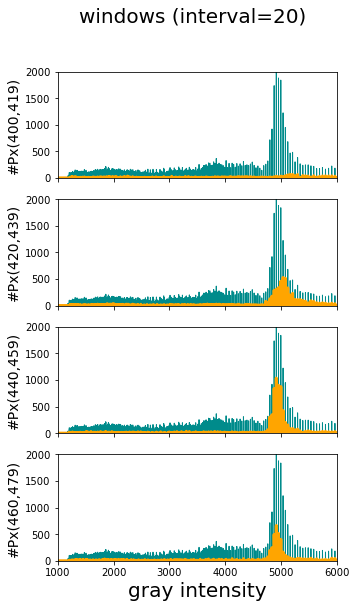

In [7]:
'''h/v window HOG'''
HOG_s = np.zeros(65536)
for i in range((480-170)):
    for j in range(640):
        index = npDepth[i][j]
        HOG_s[index] = HOG_s[index]+1
# plt.plot(HOG_s, linewidth=1.0, color='blue', label='sky')

HOG_g = np.zeros(65536)
for i in range((480-170), 480):
    for j in range(640):
        index = npDepth[i][j]
        HOG_g[index] = HOG_g[index]+1
# plt.plot(HOG_g, linewidth=1.0, color='green', label='ground')

HOG_l = np.zeros(65536)
for i in range(480):
    for j in range(320):
        index = npDepth[i][j]
        HOG_l[index] = HOG_l[index]+1
# plt.plot(HOG_l, linewidth=1.0, color='#696969', label='left')

HOG_r = np.zeros(65536)
for i in range(480):
    for j in range(320, 640):
        index = npDepth[i][j]
        HOG_r[index] = HOG_r[index]+1
# plt.plot(HOG_r, linewidth=1.0, color='#008b8b', label='right')

for p in range(5,6):
    HOG_wind = np.zeros((4,65536))
    fig, axs = plt.subplots(4,figsize=(5,9),sharex=True)
                            # nrows=2, ncols=3, figsize=(5,1):5*1(inch^2), dpi=100(pi/inch) 
    for k in range(4):
        for i in range(480):
            for j in range(80*p+k*20, 80*p+k*20+20):
                index = npDepth[i][j]
                HOG_wind[k][index] = HOG_wind[k][index]+1
        npDepthF_copy = np.copy(npDepthF)
        image_ColorMap = cv2.applyColorMap(npDepthF_copy, cv2.COLORMAP_JET);
        cv2.line(image_ColorMap, (80*p+k*20,0),(80*p+k*20,640),(255,255,255),3)
        cv2.line(image_ColorMap, (80*p+k*20+19,0),(80*p+k*20+19,640),(255,255,255),3)
        print(80*p+k*20, 80*p+k*20+20-1)
        cv2.imshow("windows", image_ColorMap)
        cv2.waitKey(0)
        
        axs[k].set_ylabel('#Px('+str(80*p+k*20)+','+str(80*p+k*20+20-1) + ')', fontsize=14)
        axs[k].plot(HOG_r, linewidth=1.0, color='#008b8b', label='right')
        # axs[k].plot(HOG_l, linewidth=1.0, color='#696969', label='left')
        axs[k].plot(HOG_wind[k], linewidth=1.0, color='orange', label='winodw', LineWidth=3)
        # ax.legend(fontsize=16)
        fig.suptitle('windows (interval=20)', fontsize=20)
    for ax in axs.flat:
        ax.set_xlabel('gray intensity', fontsize=20)
        ax.set_xlim(1000, 6000)
        ax.set_ylim(0, 2000)
        ax.label_outer()
    plt.show()

cv2.destroyAllWindows()

In [7]:
'''filter out >5.5m'''
height, width = npDepth.shape
layer=17 # horizontal line
npDepthF_copy = np.copy(npDepthF)
ret, npDepthF_copy = cv2.threshold(npDepthF_copy, 220, 255, cv2.THRESH_TOZERO_INV) # filter out 5.5m
cv2.imshow('THRESH_TOZERO_INV', npDepthF_copy)
cv2.waitKey(0)

'''keep sky area'''
mask = np.zeros_like(npDepthF_copy)    
region_of_interest_vertices = [(0,0),(0, height-layer*10),(width, height-layer*10),(width,0)]
cv2.fillPoly(mask, np.array([region_of_interest_vertices], np.int32), 255)
masked_img = cv2.bitwise_and(npDepthF_copy, mask)
cv2.imshow('filterOut ground', masked_img)
cv2.waitKey(0)

'''keep foreground object(trunk)'''
ret, binarized_img = cv2.threshold(masked_img, 170, 255, cv2.THRESH_BINARY_INV)
cv2.imshow('binarized', binarized_img)
cv2.waitKey(0)

'''draw contours'''
contours, hierarchy = cv2.findContours(binarized_img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 
npDepthF_copy = np.copy(npDepthF)
image_ColorMap = cv2.applyColorMap(npDepthF_copy, cv2.COLORMAP_JET)
cv2.drawContours(npDepthF_copy, contours,-1,(0,0,0),8)  # contour is a list
cv2.imshow('contours', npDepthF_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()

(108455,)


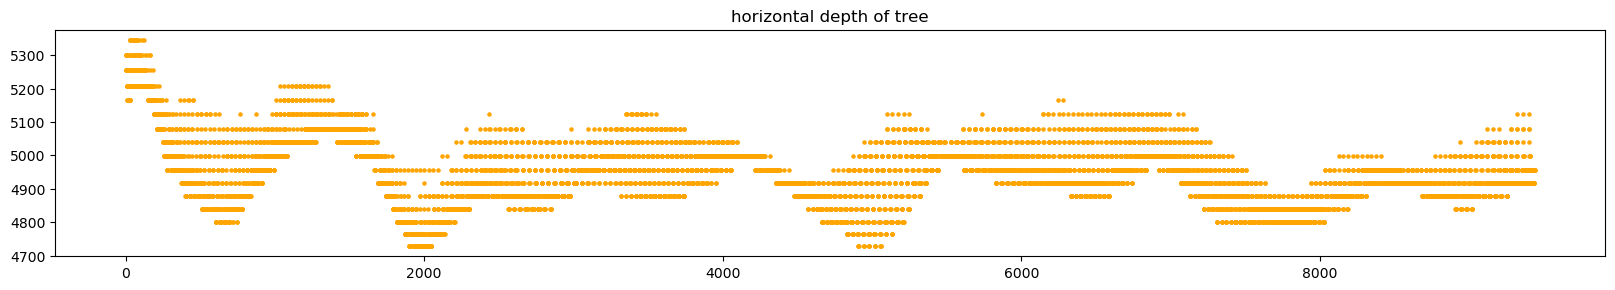

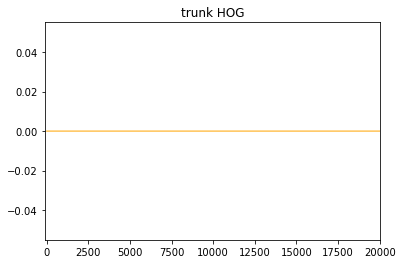

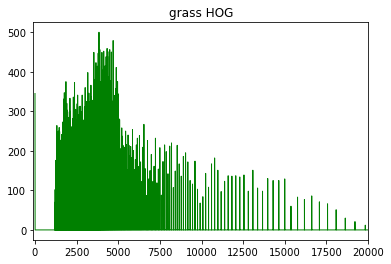

In [46]:
cv2.drawContours(binarized_img, contours,-1,(0),8)  # avoid some unwanted side point
cv2.imshow('binarized', binarized_img)
cv2.waitKey(100)

accu_t_amount = 0
accu_t_depth = 0
tree_depth = np.array([])
accu_g_amount = 0
accu_g_depth = 0
ground_depth = np.array([])
HOG_trunk = np.zeros(65536)

for i in range(height-layer*10):
    for j in range(width):
        if binarized_img[i][j]!=0:
            # index = npDepth[i][j]
            accu_t_depth = accu_t_depth + npDepth[i][j]
            tree_depth = np.append(tree_depth, npDepth[i][j])
            accu_t_amount = accu_t_amount + 1
            # HOG_trunk[index] = HOG_trunk[index] + 1
for i in range(height-layer*10, height):
    for j in range(width):
        if npDepth[i][j]!=0:
            # index = npDepth[i][j]
            accu_g_depth = accu_g_depth + npDepth[i][j]
            ground_depth = np.append(ground_depth, npDepth[i][j])
            accu_g_amount = accu_g_amount + 1
            # HOG_trunk[index] = HOG_trunk[index] + 1
print(ground_depth.shape)
            
'''analysis'''
meanTree = statistics.mean(tree_depth)
medianTree = statistics.median(tree_depth)
stdevTree = statistics.stdev(tree_depth)

meanGrass = statistics.mean(ground_depth)
medianGrass = statistics.median(ground_depth)
stdevGrass = statistics.stdev(ground_depth)

npDepthF_copy_c = cv2.cvtColor(npDepthF_copy, cv2.COLOR_GRAY2BGR)
cv2.putText(npDepthF_copy_c, #numpy array on which text is written
            'mean: '+str(np.trunc(meanTree)), #text
            (400,200+15), #position at which writing has to start
            cv2.FONT_HERSHEY_SIMPLEX, #font family
            0.9, #font size
            (255,0,0), #font color
            3) #font stroke
cv2.putText(npDepthF_copy_c, #numpy array on which text is written
            'median: '+str(medianTree), #text
            (400,200+45), #position at which writing has to start
            cv2.FONT_HERSHEY_SIMPLEX, #font family
            0.9, #font size
            (0,255,0), #font color
            3) #font stroke
cv2.putText(npDepthF_copy_c, #numpy array on which text is written
            'stdev: '+str(np.trunc(stdevTree)), #text
            (400,200+75), #position at which writing has to start
            cv2.FONT_HERSHEY_SIMPLEX, #font family
            0.9, #font size
            (0,0,255), #font color
            3) #font stroke

cv2.putText(npDepthF_copy_c, #numpy array on which text is written
            'mean: '+str(np.trunc(meanGrass)), #text
            (200,300+15), #position at which writing has to start
            cv2.FONT_HERSHEY_SIMPLEX, #font family
            0.9, #font size
            (255,0,0), #font color
            3) #font stroke
cv2.putText(npDepthF_copy_c, #numpy array on which text is written
            'median: '+str(medianGrass), #text
            (200,300+45), #position at which writing has to start
            cv2.FONT_HERSHEY_SIMPLEX, #font family
            0.9, #font size
            (0,255,0), #font color
            3) #font stroke
cv2.putText(npDepthF_copy_c, #numpy array on which text is written
            'stdev: '+str(np.trunc(stdevGrass)), #text
            (200,300+75), #position at which writing has to start
            cv2.FONT_HERSHEY_SIMPLEX, #font family
            0.9, #font size
            (0,0,255), #font color
            3) #font stroke


cv2.imshow('statistic', npDepthF_copy_c)
cv2.waitKey(0)

fig4, ax4=plt.subplots(figsize=(20,3), dpi=100)
plt.scatter(range(tree_depth.shape[0]),tree_depth, s=5,color='orange')
plt.title('horizontal depth of tree')
plt.show()
plt.plot(HOG_trunk, linewidth=1.0, color='orange')
plt.title('trunk HOG')
plt.xlim([-100,20000])
plt.show()
plt.plot(HOG_g, linewidth=1.0, color='green')
plt.title('grass HOG')
plt.xlim([-100,20000])
plt.show()

npDepthF_copy = np.copy(npDepthF)
image_ColorMap = cv2.applyColorMap(npDepthF_copy, cv2.COLORMAP_JET)

'''
tree_depth = np.array([])
for j in range(width):
    if binarized_img[30][j]!=0:
        tree_depth = np.append(tree_depth, npDepth[i][j])
plt.scatter(range(tree_depth.shape[0]), tree_depth)
plt.show()
cv2.line(image_ColorMap, (0,30),(640,30),(255,255,255),3)
cv2.imshow('a',image_ColorMap)
cv2.waitKey(0)

tree_depth = np.array([])
for j in range(width):
    if binarized_img[130][j]!=0:
        tree_depth = np.append(tree_depth, npDepth[i][j])
plt.scatter(range(tree_depth.shape[0]), tree_depth)
plt.show()
cv2.line(image_ColorMap, (0,130),(640,130),(255,255,255),3)
cv2.imshow('a',image_ColorMap)
cv2.waitKey(0)

tree_depth = np.array([])
for j in range(width):
    if binarized_img[200][j]!=0:
        tree_depth = np.append(tree_depth, npDepth[i][j])
plt.scatter(range(tree_depth.shape[0]), tree_depth)
plt.show()
cv2.line(image_ColorMap, (0,200),(640,200),(255,255,255),3)
cv2.imshow('a',image_ColorMap)
cv2.waitKey(0)

tree_depth = np.array([])
for j in range(width):
    if binarized_img[260][j]!=0:
        tree_depth = np.append(tree_depth, npDepth[i][j])
plt.scatter(range(tree_depth.shape[0]), tree_depth)
plt.show()
cv2.line(image_ColorMap, (0,260),(640,260),(255,255,255),3)
cv2.imshow('a',image_ColorMap)
cv2.waitKey(0)
'''
cv2.destroyAllWindows()
    

In [5]:
npDepth.shape

(480, 640)

In [25]:
def depth(x,y):
    return npDepth[x][y]

In [26]:
class Point3D:
    x: int = 0
    y: int = 0
    z: int = 0
cy_d = 424
cx_d = 241
fy_d = 424
fx_d = 424

npElavation = np.array([])
for i in range(480):
    for j in range(640):
        x_d = i
        y_d = j
        P3D = Point3D
        P3D.x = (-x_d + cx_d) * depth(x_d,y_d) / fx_d
        P3D.y = (-y_d + cy_d) * depth(x_d,y_d) / fy_d
        P3D.z = depth(x_d,y_d)
        npElavation = np.append(npElavation, P3D.x)
        

In [27]:
npElavation = npElavation.reshape(480,-1);
npElavation.shape

(480, 640)

In [28]:
'''plot 3D color surface'''
%matplotlib qt
fig3, ax3 = plt.subplots(subplot_kw={"projection": "3d"})
y = np.linspace(0,479,480) # data of [:x] column
x = np.linspace(0,639,640) # data of [x:] row
X,Y = np.meshgrid(x,y)
print(npDepthF.shape)
initial_cmap = cm.get_cmap('rainbow')
# reversed_cmap=initial_cmap.reversed()
surf = ax3.plot_surface(X, Y, npElavation, cmap=initial_cmap)
plt.title('Elevator mapping', fontsize='15')
plt.xlabel('X[pixel]', fontsize='15')
plt.ylabel('Y[pixel]', fontsize='15')
fig3.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

(480, 640)


In [34]:
a = [5,4,3,2,1]
for i in range(4,0,-1):
    for j in range(0, i):
        if a[j]>a[j+1]:
            tmp = a[j]
            a[j] = a[j+1]
            a[j+1] = tmp
a

[1, 2, 3, 4, 5]